# Integrating into Pipelines for Clustering

Starting off, we import a few required Python resources. While there are quite a few in there, notice we are grabbing the `make_pipeline` method from Sci-Kit Learn. We are going to be building pipelines!

In [1]:
import os
from pathlib import Path
import sys

from arcgis.features import GeoAccessor
from arcgis.geoenrichment import Country
from arcgis.gis import GIS
from dotenv import find_dotenv, load_dotenv
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline

# load the "autoreload" extension so that code can change, & always reload modules so that as you change code in src, it gets loaded
%load_ext autoreload
%autoreload 2

In [2]:
# load environment variables from .env
load_dotenv(find_dotenv())

# paths to input data
dir_prj = Path.cwd().parent
dir_data = dir_prj/'data'
dir_raw = dir_data/'raw'

# import the two preprocessors from the examples
sys.path.append(str(dir_prj/'src'))
from ba_samples.preprocessing import EnrichStandardGeography, KeepOnlyEnrichColumns, ArrayToDataFrame

# specifically, the data being used for this example - pickled dataframes
postal_codes_pth = dir_raw/'pdx_postal_codes.pkl'
block_groups_pth = dir_raw/'pdx_block_groups.pkl'

## Pipeline for Zip Codes

We start by getting a list of standard geography codes to use from the demonstration postal code data, just a list of zip codes.

In [3]:
postal_code_df = pd.read_pickle(postal_codes_pth)
postal_code_lst = list(postal_code_df['ID'])

print(postal_code_lst)

['97038', '97101', '97304', '97347', '97362', '97375', '97396', '97002', '97003', '97004', '97005', '97006', '97007', '97008', '97009', '97013', '97015', '97016', '97017', '97018', '97022', '97024', '97027', '97030', '97032', '97034', '97035', '97036', '97042', '97045', '97048', '97051', '97053', '97054', '97056', '97060', '97062', '97064', '97068', '97070', '97071', '97078', '97080', '97086', '97089', '97106', '97109', '97111', '97113', '97114', '97115', '97116', '97117', '97119', '97123', '97124', '97125', '97127', '97128', '97132', '97133', '97140', '97144', '97148', '97201', '97202', '97203', '97204', '97205', '97206', '97209', '97210', '97211', '97212', '97213', '97214', '97215', '97216', '97217', '97218', '97219', '97220', '97221', '97222', '97223', '97224', '97225', '97227', '97229', '97230', '97231', '97232', '97233', '97236', '97239', '97266', '97267', '97378', '98601', '98604', '98606', '98607', '98629', '98642', '98649', '98660', '98661', '98662', '98663', '98664', '98665', 

### Get a Local Country

To enrich, we need a `Country` object instance. As part of the constructor, we need to tell the object what Business Analyst source to use in the `gis` parameter. In this case, we are telling the object to use ArcGIS Pro with Business Analyst and local data for the United States.

In [4]:
usa_local = Country('usa', gis=GIS('pro'))

usa_local

<Country - United States 2021 ('local')>

### Select Variables

Next, we need to get some enrich variables to use. We can discover what is available using the `enrich_variables` property of the country object to retrieve a Pandas Data Frame of variables available for the country. From these tens of thousands of variables, we can prune this down to a manageable subset.

In [5]:
ev = usa_local.enrich_variables
kv = ev[
    (ev.data_collection.str.lower().str.contains('key'))
    & (ev.name.str.lower().str.endswith('cy'))
].reset_index(drop=True)

kv

,name,alias,data_collection,enrich_name,enrich_field_name
0,TOTPOP_CY,2021 Total Population,KeyUSFacts,KeyUSFacts.TOTPOP_CY,KeyUSFacts_TOTPOP_CY
1,GQPOP_CY,2021 Group Quarters Population,KeyUSFacts,KeyUSFacts.GQPOP_CY,KeyUSFacts_GQPOP_CY
2,DIVINDX_CY,2021 Diversity Index,KeyUSFacts,KeyUSFacts.DIVINDX_CY,KeyUSFacts_DIVINDX_CY
3,TOTHH_CY,2021 Total Households,KeyUSFacts,KeyUSFacts.TOTHH_CY,KeyUSFacts_TOTHH_CY
4,AVGHHSZ_CY,2021 Average Household Size,KeyUSFacts,KeyUSFacts.AVGHHSZ_CY,KeyUSFacts_AVGHHSZ_CY
5,MEDHINC_CY,2021 Median Household Income,KeyUSFacts,KeyUSFacts.MEDHINC_CY,KeyUSFacts_MEDHINC_CY
6,AVGHINC_CY,2021 Average Household Income,KeyUSFacts,KeyUSFacts.AVGHINC_CY,KeyUSFacts_AVGHINC_CY
7,PCI_CY,2021 Per Capita Income,KeyUSFacts,KeyUSFacts.PCI_CY,KeyUSFacts_PCI_CY
8,TOTHU_CY,2021 Total Housing Units,KeyUSFacts,KeyUSFacts.TOTHU_CY,KeyUSFacts_TOTHU_CY
9,OWNER_CY,2021 Owner Occupied HUs,KeyUSFacts,KeyUSFacts.OWNER_CY,KeyUSFacts_OWNER_CY


### Get Standard Geography Name

Using the `levels` property, we can see the value we need to use for specifying the specfic zip code level, `zip5`.

In [6]:
usa_local.levels

,level_name,alias,level_id,id_field,name_field,singular_name,plural_name,admin_level
0,block_groups,Block Groups,US.BlockGroups,ID,NAME,Block Group,Block Groups,Admin11
1,tracts,Census Tracts,US.Tracts,ID,NAME,Census Tract,Census Tracts,Admin10
2,places,Cities and Towns (Places),US.Places,ID,NAME,Place,Places,Admin9
3,zip5,ZIP Codes,US.ZIP5,ID,NAME,ZIP Code,ZIP Codes,Admin4
4,csd,County Subdivisions,US.CSD,ID,NAME,County Subdivision,County Subdivisions,Admin7
5,counties,Counties,US.Counties,ID,NAME,County,Counties,Admin3
6,cbsa,CBSAs,US.CBSA,ID,NAME,CBSA,CBSAs,Admin5
7,cd,Congressional Districts,US.CD,ID,NAME,Congressional District,Congressional Districts,Admin8
8,dma,DMAs,US.DMA,ID,NAME,DMA,DMAs,Admin6
9,states,States,US.States,ID,NAME,State,States,Admin2


### Enrich Preprocessor

The `enrich` method can be wrapped into the `transform` method of a SciKit-Learn Transformer, specifically a preprocessor, to function just like any other preprocessor. In this case, not only have I wrapped the preprocessor, I also have created this preprocessor for specific inputs, standard geographies.

In [7]:
from ba_samples.preprocessing import EnrichStandardGeography

enrich_preprocessor = EnrichStandardGeography(usa_local, enrich_variables=kv, standard_geography_level='zip5', return_geometry=False)

enrich_df = enrich_preprocessor.fit_transform(postal_code_lst)

enrich_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id_field            133 non-null    object 
 1   area_desc           133 non-null    object 
 2   ta_desc             133 non-null    object 
 3   names               133 non-null    object 
 4   has_data            133 non-null    int32  
 5   aggregation_method  133 non-null    object 
 6   totpop_cy           133 non-null    float64
 7   gqpop_cy            133 non-null    float64
 8   divindx_cy          133 non-null    float64
 9   tothh_cy            133 non-null    float64
 10  avghhsz_cy          133 non-null    float64
 11  medhinc_cy          133 non-null    float64
 12  avghinc_cy          133 non-null    float64
 13  pci_cy              133 non-null    float64
 14  tothu_cy            133 non-null    float64
 15  owner_cy            133 non-null    float64
 16  renter_c

In [8]:
enrich_df.head()

,id_field,area_desc,ta_desc,names,has_data,aggregation_method,totpop_cy,gqpop_cy,divindx_cy,tothh_cy,...,renter_cy,vacant_cy,medval_cy,avgval_cy,popgrw10_cy,hhgrw10_cy,famgrw10_cy,dpop_cy,dpopwrk_cy,dpopres_cy
0,97038,97038,TA from geography Layer: 97038,Molalla,1,BlockApportionment:US.BlockGroups;PointsLayer:...,17305.0,56.0,42.4,6144.0,...,1552.0,293.0,388300.0,442226.0,1.18,1.20,1.00,13803.0,4468.0,9335.0
1,97002,97002,TA from geography Layer: 97002,Aurora,1,BlockApportionment:US.BlockGroups;PointsLayer:...,5951.0,52.0,54.3,2285.0,...,389.0,85.0,491246.0,565932.0,1.09,1.15,0.97,7040.0,3847.0,3193.0
2,97347,97347,TA from geography Layer: 97347,Grand Ronde,1,BlockApportionment:US.BlockGroups;PointsLayer:...,2163.0,0.0,53.5,850.0,...,242.0,60.0,375287.0,446223.0,1.28,1.31,1.13,2296.0,907.0,1389.0
3,97013,97013,TA from geography Layer: 97013,Canby,1,BlockApportionment:US.BlockGroups;PointsLayer:...,25403.0,104.0,54.2,9139.0,...,2458.0,340.0,392366.0,437940.0,0.96,0.98,0.85,21914.0,9136.0,12778.0
4,97017,97017,TA from geography Layer: 97017,Colton,1,BlockApportionment:US.BlockGroups;PointsLayer:...,3194.0,0.0,16.9,1133.0,...,125.0,58.0,434483.0,480442.0,0.68,0.72,0.58,2405.0,687.0,1718.0


### Filtering Columns

The output from `enrich` includes a number of metadata columns. If performing subsequent analysis, we need to prune these columns. We can use another preprocessor for this as well, one only keeping columns with enriched values.

In [9]:
from ba_samples.preprocessing import KeepOnlyEnrichColumns

enrich_zip_pipe =  make_pipeline(
    EnrichStandardGeography(usa_local, enrich_variables=kv, standard_geography_level='zip5', return_geometry=False),
    KeepOnlyEnrichColumns(usa_local, id_column='id_field', keep_geometry=False)
)

enrich_df = enrich_zip_pipe.fit_transform(postal_code_lst)

enrich_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 133 entries, 97038 to 98671
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   totpop_cy   133 non-null    float64
 1   gqpop_cy    133 non-null    float64
 2   divindx_cy  133 non-null    float64
 3   tothh_cy    133 non-null    float64
 4   avghhsz_cy  133 non-null    float64
 5   medhinc_cy  133 non-null    float64
 6   avghinc_cy  133 non-null    float64
 7   pci_cy      133 non-null    float64
 8   tothu_cy    133 non-null    float64
 9   owner_cy    133 non-null    float64
 10  renter_cy   133 non-null    float64
 11  vacant_cy   133 non-null    float64
 12  medval_cy   133 non-null    float64
 13  avgval_cy   133 non-null    float64
 14  dpop_cy     133 non-null    float64
 15  dpopwrk_cy  133 non-null    float64
 16  dpopres_cy  133 non-null    float64
dtypes: float64(17)
memory usage: 18.7+ KB


In [10]:
enrich_df.head()

,keyusfacts_totpop_cy,keyusfacts_gqpop_cy,keyusfacts_divindx_cy,keyusfacts_tothh_cy,keyusfacts_avghhsz_cy,keyusfacts_medhinc_cy,keyusfacts_avghinc_cy,keyusfacts_pci_cy,keyusfacts_tothu_cy,keyusfacts_owner_cy,keyusfacts_renter_cy,keyusfacts_vacant_cy,keyusfacts_medval_cy,keyusfacts_avgval_cy,keyusfacts_popgrw10cy,keyusfacts_hhgrw10cy,keyusfacts_famgrw10cy,keyusfacts_dpop_cy,keyusfacts_dpopwrk_cy,keyusfacts_dpopres_cy
id_field,,,,,,,,,,,,,,,,,,,,
83801,8497.0,0.0,13.6,3142.0,2.70,62413.0,78746.0,30156.0,3563.0,2660.0,482.0,421.0,382542.0,391184.0,2.07,2.09,1.92,6502.0,1962.0,4540.0
83803,656.0,0.0,10.5,341.0,1.92,43344.0,61732.0,29472.0,659.0,264.0,76.0,318.0,391333.0,403113.0,1.76,1.80,1.56,499.0,145.0,354.0
83810,1090.0,4.0,11.7,479.0,2.27,60088.0,89006.0,38340.0,579.0,406.0,72.0,100.0,437903.0,464383.0,0.94,0.96,0.76,762.0,246.0,516.0
83814,28546.0,609.0,21.2,12454.0,2.24,57487.0,80524.0,34960.0,15054.0,6855.0,5599.0,2600.0,377722.0,508589.0,1.86,1.91,1.72,38178.0,23011.0,15167.0
83815,38614.0,617.0,24.1,15247.0,2.49,56872.0,73431.0,29323.0,16393.0,9649.0,5598.0,1146.0,308198.0,374194.0,1.79,1.78,1.51,37345.0,15891.0,21454.0


## Clustering Block Groups Using Demographics

Stepping up our game a little, now we are getting all the US Census Block Groups in Portland because we are interested in what demographic variables have the most differences in Portland, and are going to use a SciKit-Learn pipeline to streamline the process.

In [10]:
block_groups_df = pd.read_pickle(block_groups_pth)
block_groups_lst = list(block_groups_df['ID'])

print(f'Block Group Count: {len(block_groups_lst):,}')

Block Group Count: 1,421


### Source - ArcGIS Online

This time around, we no longer are using local resources. Now, we are switching to ArcGIS Online.

In [12]:
gis_agol = GIS(url=os.getenv('ESRI_GIS_URL'), username=os.getenv('ESRI_GIS_USERNAME'), password=os.getenv('ESRI_GIS_PASSWORD'))
usa_agol = Country('usa', gis=gis_agol)

usa_agol

<Country - United States (GIS @ https://baqa.mapsqa.arcgis.com version:9.4)>

### Selecting Variables

This time around, we are going big. By just grabbing a lot of categories, we are selecting a wide swath of demographic varaiables. There wasn not a tremenedously emperical method used to retrieve these categories. I just grabbed quite a few. Below, please notice how I used some naming conventions to filter out some values to exclude.

In [13]:
collections = ['classofworker', 'commute', 'disability', 'disposableincome', 'disposableincome', 'educationalattainment', 
               'financial', 'foodstampssnap', 'gender', 'generations', 'groupquarters', 'health', 'healthinsurancecoverage', 
               'homevalue', 'householdincome', 'households', 'householdsbyageofhouseholder', 'householdsbysize', 
               'householdtotals', 'householdtype', 'housingbyageofhouseholder', 'housingbysize', 'housingcosts', 
               'housinghousehold', 'housingunittotals', 'industry', 'internetcomputerusage', 'keyusfacts',
               'language', 'network', 'occupation', 'wealth', 'veterans']


ev = usa_agol.enrich_variables

enrich_vars = ev[
    (ev.data_collection.isin(collections))
    & (~ev.alias.str.lower().str.contains('index'))  # exclude calculated indexes
    & (~ev.name.str.lower().str.endswith('_a'))      # exclude averages
    & (~ev.name.str.lower().str.contains('_fy'))     # exclude future year
    & (~ev.name.str.lower().str.contains('fy_'))     # exclude another future year pattern
    & (~ev.alias.str.contains('2010'))               # exclude 2010 census variables - we're not living in the past anymore
].drop_duplicates('name').reset_index(drop=True)

enrich_vars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1686 entries, 0 to 1685
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   name               1686 non-null   object
 1   alias              1686 non-null   object
 2   data_collection    1686 non-null   object
 3   enrich_name        1686 non-null   object
 4   enrich_field_name  1686 non-null   object
 5   description        1686 non-null   object
 6   vintage            1686 non-null   object
 7   units              1686 non-null   object
dtypes: object(8)
memory usage: 105.5+ KB


Just double checking, we can quickly see the correct value we need to use for United States Census Block Groups is `block_groups`.

In [14]:
usa_agol.levels

,level_name,singular_name,plural_name,alias,level_id,admin_level
0,block_groups,Block Group,Block Groups,Block Groups,US.BlockGroups,
1,tracts,Census Tract,Census Tracts,Census Tracts,US.Tracts,
2,places,Place,Places,Cities and Towns (Places),US.Places,
3,zip5,ZIP Code,ZIP Codes,ZIP Codes,US.ZIP5,Admin4
4,csd,County Subdivision,County Subdivisions,County Subdivisions,US.CSD,
5,counties,County,Counties,Counties,US.Counties,Admin3
6,cbsa,CBSA,CBSAs,CBSAs,US.CBSA,
7,cd,Congressional District,Congressional Districts,Congressional Districts,US.CD,
8,dma,DMA,DMAs,DMAs,US.DMA,
9,states,State,States,States,US.States,Admin2


### Get Demographics

Just like before, we are going to enrich, but this time around we are using a LOT of data - over 1,500 variables. This time around, we are including the geometry so we can use it later.

In [15]:
# run the enrich steps autonomously so we can access the keeper properties in later steps
enrich_pipe = make_pipeline(
    EnrichStandardGeography(usa_agol, enrich_variables=enrich_vars, standard_geography_level='block_groups', return_geometry=True),
    KeepOnlyEnrichColumns(usa_agol, keep_geometry=True)
)
enrich_df = enrich_pipe.fit_transform(block_groups_lst)

enrich_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1421 entries, 0 to 1420
Columns: 1324 entries, acscivemp to SHAPE
dtypes: float64(67), geometry(1), int64(1256)
memory usage: 14.4 MB


#### Get Just the Enriched Columns

Following enrichment, now we are getting just the columns _not_ containing the geometry, the polygon shapes of the Block Groups. Notice the `geometry` date type is _no longer_ listed.

In [16]:
demographic_cols = [c for c in enrich_df.columns if c != enrich_df.spatial.name]
training_df = enrich_df.loc[:,demographic_cols]

training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1421 entries, 0 to 1420
Columns: 1323 entries, acscivemp to acstotpop
dtypes: float64(67), int64(1256)
memory usage: 14.3 MB


### Data Cleanup

Since subsequent steps need standard scaled data and have difficulty with zero variance and missing values, we use tools from Sci-Kit Learn to clean up the data.

In [17]:
from sklearn.cluster import KMeans

from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

scale_pipe = make_pipeline(
    MinMaxScaler(),                         # get on same scale - just using because it is simple
    VarianceThreshold(threshold=0.0),       # drop zero variance variables
    SimpleImputer()                         # using defaults, filling nulls with mean
)

scaled_arr = scale_pipe.fit_transform(training_df)

scaled_arr

array([[0.11816762, 0.16923077, 0.66666667, ..., 0.        , 0.        ,
        0.19456258],
       [0.1832379 , 0.17342657, 0.33333333, ..., 0.        , 0.        ,
        0.23329283],
       [0.07105674, 0.18881119, 0.66666667, ..., 0.        , 0.        ,
        0.1240887 ],
       ...,
       [0.15955232, 0.12167832, 0.33333333, ..., 0.        , 0.        ,
        0.20990279],
       [0.0840708 , 0.23636364, 0.66666667, ..., 0.        , 0.        ,
        0.13456865],
       [0.26106195, 0.21818182, 0.33333333, ..., 0.        , 0.        ,
        0.30726002]])

### Dimensionalty Reduction

Over 1,000 variables is a lot to process. To speed up the process, we first are going to use Principal Component Analysis (PCA) for dimensionality reduction, using a scree plot to ascertain how many components to create. In this case, we are going with 200 to retain roughly 90% of the variation in the data.

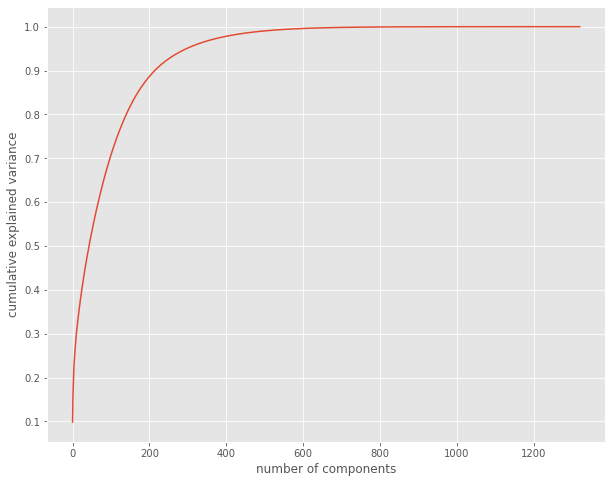

In [18]:
from sklearn.decomposition import PCA

pca = PCA().fit(scaled_arr)

plt.style.use('ggplot')
plt.figure(figsize=(10,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.show()

### Clustering

From the scree plot we know the number of clusters to use with PCA, so we are now going to combine this with K-Means Clustering in a succinct pipeline. Once we have the clusters created, we then will create a new spatially enabled Pandas data frame by combining the output clusters with the geometry returned from geoenrichment earlier.

In [19]:
from sklearn.cluster import KMeans

cluster_pipe = make_pipeline(
    PCA(n_components=200),
    KMeans(n_clusters=5)
)
cluster_pipe.fit_transform(scaled_arr)

cluster_df = pd.DataFrame(zip(block_groups_lst, cluster_pipe.named_steps.kmeans.labels_, enrich_df['SHAPE']), 
                          columns=['fips', 'cluster_id', 'SHAPE'])
cluster_df.spatial.set_geometry('SHAPE')

cluster_df.info()
cluster_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1421 entries, 0 to 1420
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   fips        1421 non-null   object  
 1   cluster_id  1421 non-null   int32   
 2   SHAPE       1421 non-null   geometry
dtypes: geometry(1), int32(1), object(1)
memory usage: 27.9+ KB


,fips,cluster_id,SHAPE
0,410710305021,2,"{""rings"": [[[-123.56601700006303, 45.216389999..."
1,410050237001,1,"{""rings"": [[[-122.61617099963205, 45.267457999..."
2,410050237002,4,"{""rings"": [[[-122.5704800001157, 45.2375169997..."
3,410050237003,1,"{""rings"": [[[-122.5111050007072, 45.2601139996..."
4,410050237004,1,"{""rings"": [[[-122.50749899966338, 45.230098999..."


### Dissolve Clusters

For visualization on a map and also for further investigation using Inforgaphics, we need the geometries consolidated into a single geometry per cluster. The ArcGIS Online Geometry engine can be used through the `arcgis.geometry.union` method to accomplish this.

In [20]:
from arcgis.geometry import union

def dissolve_by_cluster_id(cluster_id):
    """Helper to dissolve geometries based on the cluster_id."""
    # pull all the geometries out of the cluster dataframe matching the cluster id as a list
    cluster_geom_lst = list(cluster_df[cluster_df['cluster_id'] == cluster_id]['SHAPE'])
    
    # use the ArcGIS Online geometry service to combine all the geometeries into one
    dissolved_cluster_geom = union(cluster_geom_lst, gis=gis_agol)
    
    return dissolved_cluster_geom

In [21]:
uniq_cluster_id_lst = cluster_df['cluster_id'].unique()
uniq_cluster_id_lst.sort()

cluster_geom_lst = []
for c_id in uniq_cluster_id_lst:
    c_geom = dissolve_by_cluster_id(c_id)
    cluster_geom_lst.append(c_geom)
    print(f'Created geometry for cluster id {c_id}')

dissolved_cluster_df = pd.DataFrame(zip(uniq_cluster_id_lst, cluster_geom_lst), columns=['cluster_id', 'SHAPE'])
dissolved_cluster_df.spatial.set_geometry('SHAPE')

dissolved_cluster_df

Created geometry for cluster id 0
Created geometry for cluster id 1
Created geometry for cluster id 2
Created geometry for cluster id 3
Created geometry for cluster id 4


,cluster_id,SHAPE
0,0,"{""rings"": [[[-122.58948899999996, 45.181993000..."
1,1,"{""rings"": [[[-122.61984599899995, 45.118054999..."
2,2,"{""rings"": [[[-123.38401899999997, 45.110430000..."
3,3,"{""rings"": [[[-123.45598799999999, 45.125803999..."
4,4,"{""rings"": [[[-123.37559099899994, 45.094734000..."


## Visualizing, Sharing and Interrogating

Both outputs from the clustering are spatially enabled Pandas data frames, and can easily be shared with ArcGIS Online. From there, the results of these analyses can be quickly visualized in maps and mapping applications, shared to communicate results, and further interrogated through Infographics.

In [22]:
bg_lyr = cluster_df.spatial.to_featurelayer('pdx_cluster_block_groups', 
                                            gis=gis_agol, 
                                            tags=['pdx', 'machine learning', 'clustering'],
                                            service_name='pdx_cluster_block_groups')

bg_lyr

<Item title:"pdx_cluster_block_groups" type:Feature Layer Collection owner:jmccune_baqa>

In [23]:
clstr_lyr = dissolved_cluster_df.spatial.to_featurelayer('pdx_clusters', 
                                                         gis=gis_agol, 
                                                         tags=['pdx', 'machine learning', 'clustering'], 
                                                         service_name='pdx_clusters')

clstr_lyr

<Item title:"pdx_clusters" type:Feature Layer Collection owner:jmccune_baqa>